<a href="https://colab.research.google.com/github/Felgaba/HSE_DS_MasterTrack/blob/main/Image_processing_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q pyspark

     |████████████████████████████████| 281.4 MB 48 kB/s 
     |████████████████████████████████| 199 kB 63.4 MB/s 


In [ ]:
!pip install Pillow==9.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 26.0 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from typing import Iterator

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, BinaryType

from PIL import Image, ImageDraw
from tensorflow.keras.applications.resnet50 import ResNet50

import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [ ]:
import os
if not os.path.isfile('imagenette2-320.tgz'):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
    !tar -xvf imagenette2-320.tgz

In [ ]:
!mkdir /content/drive/MyDrive/Programming/m5-forecasting-accuracy/data/images/mixed

mkdir: cannot create directory ‘/content/drive/MyDrive/Programming/m5-forecasting-accuracy/data/images/mixed’: File exists


In [ ]:
!find ./imagenette2-320 -maxdepth 4 -type f | \
    sort -R | \
    head -75 | \
    xargs -I{} cp {} /content/drive/MyDrive/Programming/m5-forecasting-accuracy/data/images/mixed

In [ ]:
images_dir = "/content/drive/MyDrive/Programming/m5-forecasting-accuracy/data/images/mixed"
image_df = spark.read.format("image").load(images_dir).filter("image.nChannels > 2 AND image.height < 1000")
image_df.select("image.origin", "image.height", "image.width", "image.mode", "image.nChannels").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------+------+-----+----+---------+
|origin                                                                                                          |height|width|mode|nChannels|
+----------------------------------------------------------------------------------------------------------------+------+-----+----+---------+
|file:///content/drive/MyDrive/Programming/m5-forecasting-accuracy/data/images/mixed/ILSVRC2012_val_00031333.JPEG|320   |426  |16  |3        |
|file:///content/drive/MyDrive/Programming/m5-forecasting-accuracy/data/images/mixed/n03394916_28608.JPEG        |477   |320  |16  |3        |
|file:///content/drive/MyDrive/Programming/m5-forecasting-accuracy/data/images/mixed/n02102040_602.JPEG          |320   |465  |16  |3        |
|file:///content/drive/MyDrive/Programming/m5-forecasting-accuracy/data/images/mixed/n03425413_17079.JPEG        |573   |320  |16  |3        |

In [ ]:
image_row = 40
spark_single_img = image_df.select("image").collect()[image_row]
(spark_single_img.image.origin, spark_single_img.image.mode, spark_single_img.image.nChannels )

mode = 'RGBA' if (spark_single_img.image.nChannels == 4) else 'RGB' 


In [ ]:
# get_ipython().__class__.__name__ = "ZMQInteractiveShell"

In [ ]:
from matplotlib import pyplot as plt

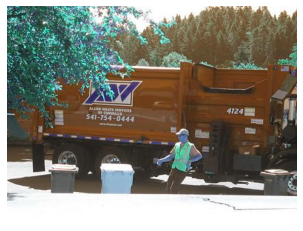

In [ ]:
plt.imshow(Image.frombytes(mode=mode, 
                data=bytes(spark_single_img.image.data), 
                size=[spark_single_img.image.width,spark_single_img.image.height]
                ))
plt.axis("off")
plt.show()

In [ ]:
def convert_bgr_array_to_rgb_array(img_array):
    B, G, R = img_array.T
    return np.array((R, G, B)).T

img = Image.frombytes(mode=mode, data=bytes(spark_single_img.image.data), size=[spark_single_img.image.width,spark_single_img.image.height])

converted_img_array = convert_bgr_array_to_rgb_array(np.asarray(img))


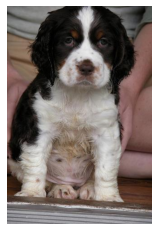

In [ ]:
plt.imshow(Image.fromarray(converted_img_array))
plt.axis("off")
plt.show()

In [ ]:
schema = StructType(image_df.select("image.*").schema.fields + [
    StructField("data_as_resized_array", ArrayType(IntegerType()), True),
    StructField("data_as_array", ArrayType(IntegerType()), True)
])

def resize_img(img_data, resize=True):
    mode = 'RGBA' if (img_data.nChannels == 4) else 'RGB' 
    img = Image.frombytes(mode=mode, data=img_data.data, size=[img_data.width, img_data.height])
    img = img.convert('RGB') if (mode == 'RGBA') else img
    img = img.resize([224, 224], resample=Image.Resampling.BICUBIC) if (resize) else img
    arr = convert_bgr_array_to_rgb_array(np.asarray(img))
    arr = arr.reshape([224*224*3]) if (resize) else arr.reshape([img_data.width*img_data.height*3])

    return arr

def resize_image_udf(dataframe_batch_iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in dataframe_batch_iterator:
        dataframe_batch["data_as_resized_array"] = dataframe_batch.apply(resize_img, args=(True,), axis=1)
        dataframe_batch["data_as_array"] = dataframe_batch.apply(resize_img, args=(False,), axis=1)
        yield dataframe_batch

resized_df = image_df.select("image.*").mapInPandas(resize_image_udf, schema)

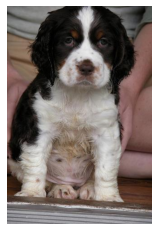

In [ ]:
row = resized_df.collect()[image_row]
plt.imshow(Image.frombytes(mode='RGB', data=bytes(row.data_as_array), size=[row.width,row.height]))
plt.axis("off")
plt.show()

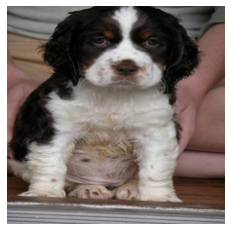

In [ ]:
plt.imshow(Image.frombytes(mode='RGB', data=bytes(row.data_as_resized_array), size=[224,224]))
plt.axis("off")
plt.show()

In [ ]:
def normalize_array(arr):
    return tf.keras.applications.resnet50.preprocess_input(arr.reshape([224,224,3]))

@pandas_udf(ArrayType(FloatType()))
def predict_batch_udf(iterator: Iterator[pd.Series]) -> Iterator[pd.Series]:
    model = ResNet50()
    for input_array in iterator:
        normalized_input = np.stack(input_array.map(normalize_array))
        preds = model.predict(normalized_input)
        yield pd.Series(list(preds))

predicted_df = resized_df.withColumn("predictions", predict_batch_udf("data_as_resized_array"))

In [ ]:
prediction_row = predicted_df.collect()[image_row]

tf.keras.applications.resnet50.decode_predictions(
    np.array(prediction_row.predictions).reshape(1,1000), top=5
)

[[('n02102040', 'English_springer', 0.4665556848049164),
  ('n02086646', 'Blenheim_spaniel', 0.3255757689476013),
  ('n02102318', 'cocker_spaniel', 0.10184824466705322),
  ('n02085782', 'Japanese_spaniel', 0.054133251309394836),
  ('n02102480', 'Sussex_spaniel', 0.0176711305975914)]]

In [ ]:
decoded_predictions_schema = StructType(predicted_df.schema.fields + [
    StructField("pred_id", ArrayType(StringType()), False),
    StructField("label", ArrayType(StringType()), False),
    StructField("score", ArrayType(FloatType()), False)
])

def top5_predictions(preds):
    return tf.keras.applications.resnet50.decode_predictions(
        np.array(preds).reshape(1,1000), top=5
    )

def top5predictions_batch_udf(iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in iterator:
        yield pd.merge(
            dataframe_batch, 
            right=pd.concat([
                pd.DataFrame(top5, columns=["pred_id", "label", "score"]).aggregate(lambda x: [x.tolist()], axis=0) for [top5] in dataframe_batch.predictions.map(top5_predictions)
                ]).reset_index(drop=True),
            left_index=True,
            right_index=True
        )

top5_predictions_df = predicted_df.mapInPandas(top5predictions_batch_udf, decoded_predictions_schema)

In [ ]:
top5_prediction = top5_predictions_df.collect()[image_row]
top5_prediction.label[0]  # gives garbage_truck

'English_springer'

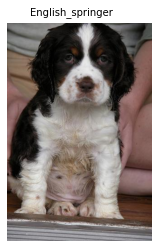

In [ ]:
def show_image_with_label(image, label):
    plt.imshow(image)
    plt.axis("off")
    plt.text(50, -20, label)
    plt.show()

show_image_with_label(Image.frombytes(mode='RGB', data=bytes(top5_prediction.data_as_array), size=[top5_prediction.width,top5_prediction.height]), top5_prediction.label[0])

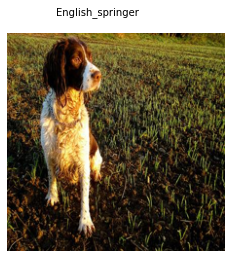

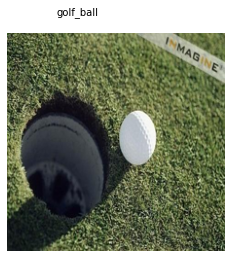

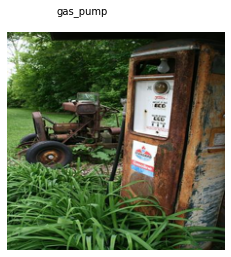

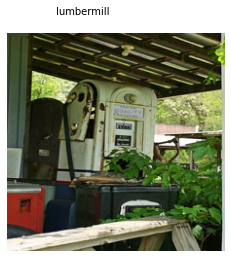

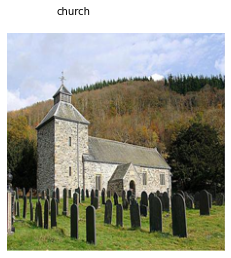

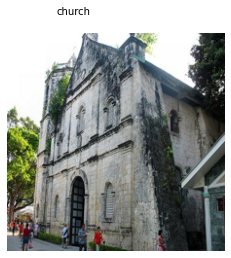

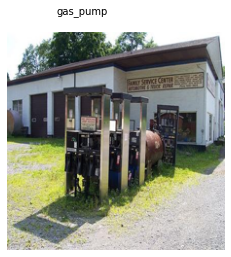

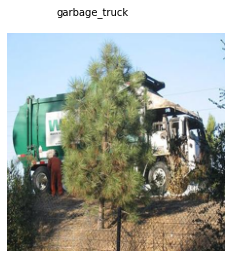

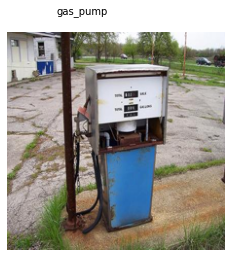

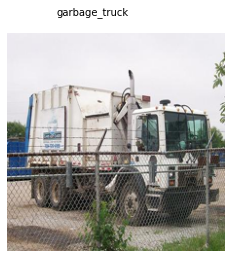

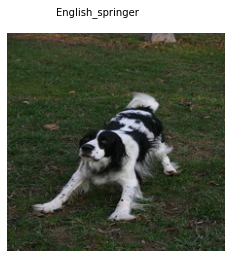

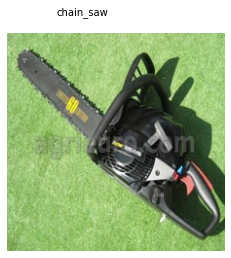

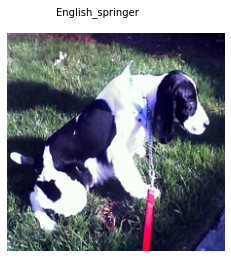

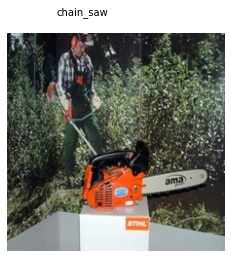

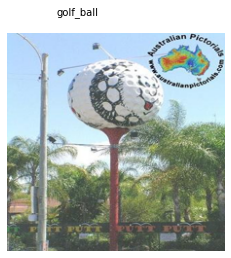

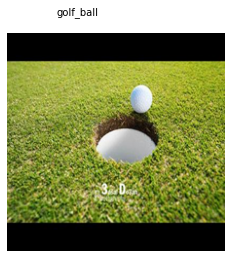

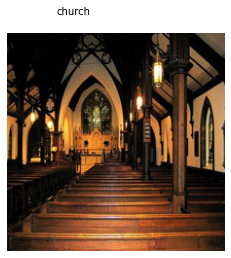

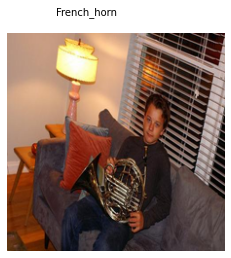

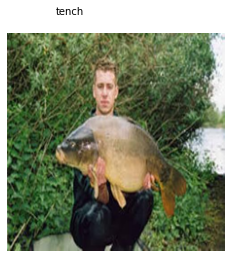

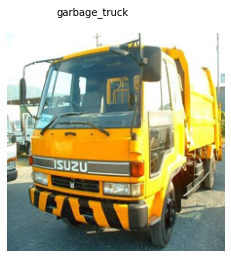

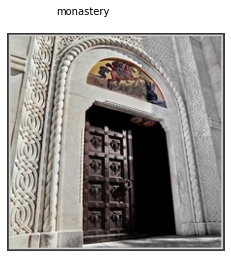

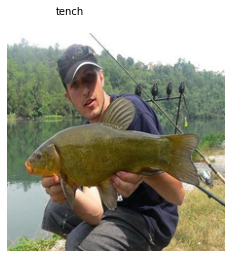

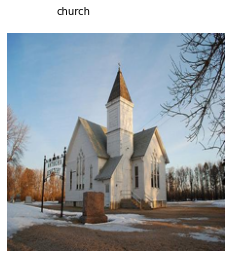

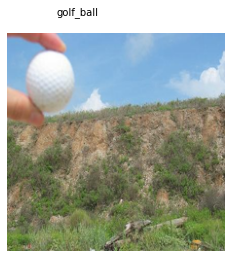

In [ ]:
for row in top5_predictions_df.collect():
    show_image_with_label(Image.frombytes(mode='RGB', data=bytes(row.data_as_resized_array), size=[224,224]), row.label[0])